<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#Read-data-from-disk" data-toc-modified-id="Read-data-from-disk-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read data from disk</a></span></li><li><span><a href="#Align-the-spectra-into-consistent-energy-bins-across-available-data" data-toc-modified-id="Align-the-spectra-into-consistent-energy-bins-across-available-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Align the spectra into consistent energy bins across available data</a></span></li><li><span><a href="#Select-the-most-highly-sampled-examples" data-toc-modified-id="Select-the-most-highly-sampled-examples-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Select the most highly sampled examples</a></span></li><li><span><a href="#Trim-and-Visualize" data-toc-modified-id="Trim-and-Visualize-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Trim and Visualize</a></span></li><li><span><a href="#Simple-Models" data-toc-modified-id="Simple-Models-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Simple Models</a></span><ul class="toc-item"><li><span><a href="#PCA-(Unsupervised)" data-toc-modified-id="PCA-(Unsupervised)-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>PCA (Unsupervised)</a></span></li><li><span><a href="#LDA-(Supervised)" data-toc-modified-id="LDA-(Supervised)-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>LDA (Supervised)</a></span></li></ul></li></ul></li><li><span><a href="#Soft-PLS-DA" data-toc-modified-id="Soft-PLS-DA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Soft PLS-DA</a></span><ul class="toc-item"><li><span><a href="#Optimize-a-Model" data-toc-modified-id="Optimize-a-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Optimize a Model</a></span></li><li><span><a href="#Explanations" data-toc-modified-id="Explanations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Explanations</a></span></li></ul></li><li><span><a href="#SIMCA" data-toc-modified-id="SIMCA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SIMCA</a></span><ul class="toc-item"><li><span><a href="#Optimize-models" data-toc-modified-id="Optimize-models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize models</a></span></li><li><span><a href="#Explanations" data-toc-modified-id="Explanations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Explanations</a></span></li></ul></li></ul></div>

In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
    !git clone https://github.com/mahynski/chemometrics.git
    !cd chemometrics; pip3 install -r requirements.txt
else:
    import sys
    sys.path.append('../../../')

import chemometrics

import matplotlib.pyplot as plt

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [7]:
import sklearn
import imblearn
import shap
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

from chemometrics.utils import plot_learning_curve, plot_confusion_matrix

shap.initjs()

# Load Data

In [3]:
import utils, os

## Read data from disk

In [4]:
head = "./Raw SPE Files/"

spectra = []
energies = []
y = []

for root, subdirectories, files in os.walk(head):
    for file in files:
        raw, bins = utils.read_spe(os.path.join(root, file), 
                                   coarsen=1, # Coarsen after alignment
                                   convert=True, # Convert from bin # to energy (eV)
                                   annihilation=False
                                  ) # Converts
        spectra.append(raw)
        energies.append(bins)
        assert(len(subdirectories) == 0)
        y.append(root.split(head+'/')[-1])
spectra = np.array(spectra)
energies = np.array(energies)
y = np.array(y)

## Align the spectra into consistent energy bins across available data

In [5]:
lowest_energy = np.min(energies)
highest_energy = np.max(energies)
nbins = int(spectra.shape[1])
dbin = (highest_energy - lowest_energy) / nbins

# [LB c0 | c1 | c2 | ... | cn UB]
bin_centers = np.arange(nbins)*dbin + dbin/2.0 + lowest_energy

def align(s, e):
    aligned = np.zeros(nbins, dtype=np.float64)
    
    def get_bin(e):
        return np.array(np.floor((e-lowest_energy)/dbin), dtype=int)
    
    for value, idx in zip(s, get_bin(e)):
        i = int(idx)
        if i == nbins:
            i -= 1
        aligned[i] += value
    return aligned

In [8]:
aligned_spectra = []
coarsen = 4

for s,e in tqdm.tqdm(zip(spectra, energies)):
    # Align
    a_ = align(s, e)
    
    # Coarsen
    c_ = np.array([np.sum(a_[coarsen*start:coarsen*(start+1)]) 
              for start in range(len(a_)//coarsen)], dtype=np.float64)
    aligned_spectra.append(c_)
    
aligned_spectra = np.array(aligned_spectra)
aligned_centers = np.array([np.sum(bin_centers[coarsen*start:coarsen*(start+1)]) 
              for start in range(len(bin_centers)//coarsen)], dtype=np.float64)

330it [00:13, 24.27it/s]


## Select the most highly sampled examples

In [9]:
%matplotlib inline

In [10]:
df = pd.DataFrame(data=aligned_spectra)
df['label'] = y

In [12]:
# To train authentication models we really need a good number of examples.  So let's set a chosen minimum number 
# of observations for a class and only work with those.  The others we can always use others as "foreign" objects.
min_counts = 20

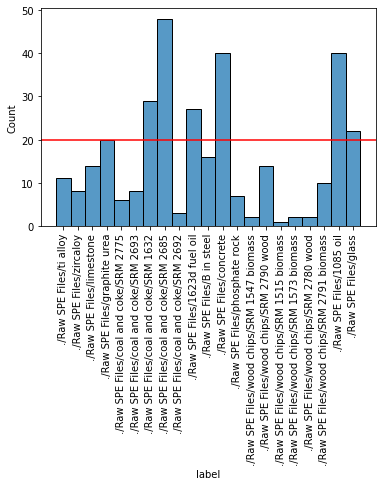

In [13]:
plt.figure()
sns.histplot(df, x='label')
_ = plt.xticks(rotation=90)
plt.axhline(min_counts, color='r')

In [16]:
cats, counts = np.unique(df['label'].values, return_counts=True)

In [17]:
df_min = df[df['label'].apply(lambda x: x in cats[counts >= min_counts])]
df_foreign = df[df['label'].apply(lambda x: x in cats[counts < min_counts])]

In [18]:
np.unique(df_min['label'], return_counts=True)

(array(['./Raw SPE Files/1085 oil', './Raw SPE Files/1623d fuel oil',
        './Raw SPE Files/coal and coke/SRM 1632',
        './Raw SPE Files/coal and coke/SRM 2685',
        './Raw SPE Files/concrete', './Raw SPE Files/glass',
        './Raw SPE Files/graphite urea'], dtype=object),
 array([40, 27, 29, 48, 40, 22, 20]))

In [19]:
np.unique(df_foreign['label'], return_counts=True)

(array(['./Raw SPE Files/B in steel',
        './Raw SPE Files/coal and coke/SRM 2692',
        './Raw SPE Files/coal and coke/SRM 2693',
        './Raw SPE Files/coal and coke/SRM 2775',
        './Raw SPE Files/limestone', './Raw SPE Files/phosphate rock',
        './Raw SPE Files/ti alloy',
        './Raw SPE Files/wood chips/SRM 1515 biomass',
        './Raw SPE Files/wood chips/SRM 1547 biomass',
        './Raw SPE Files/wood chips/SRM 1573 biomass',
        './Raw SPE Files/wood chips/SRM 2780 wood',
        './Raw SPE Files/wood chips/SRM 2790 wood',
        './Raw SPE Files/wood chips/SRM 2791 biomass',
        './Raw SPE Files/zircaloy'], dtype=object),
 array([16,  3,  8,  6, 14,  7, 11,  1,  2,  2,  2, 14, 10,  8]))

## Trim and Visualize

In [20]:
# Measurements tend to be unreliable at low energy, so choose to drop off first bins
drop = 30 # Number of bins to drop off at the beginning

In [24]:
# We can visualize the effect of using SavGol filter also
from chemometrics.preprocessing.filter import SavGol

Xt = df_min.drop(np.arange(drop).tolist()+['label'], axis=1).values
yt = df_min['label'].values
    
f = SavGol(
    window_length=7,
    polyorder=3,
    deriv=1, # Select a derivative for SavGol - try 0, 1, or 2
    delta=1
)
_ = f.fit(Xt, yt)

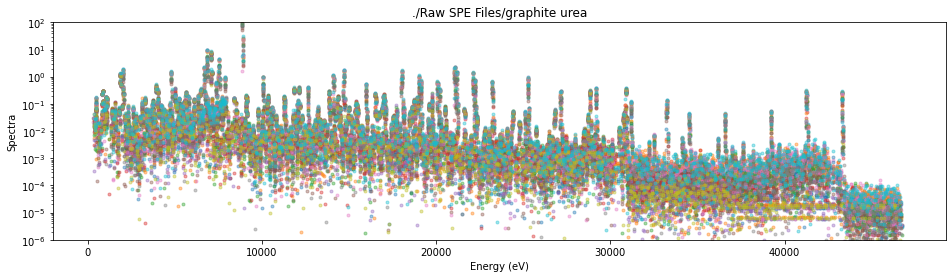

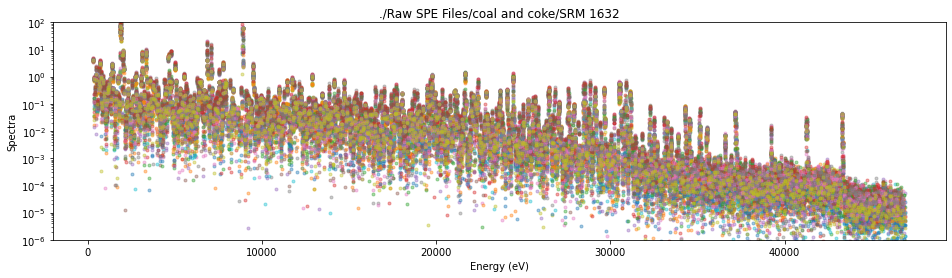

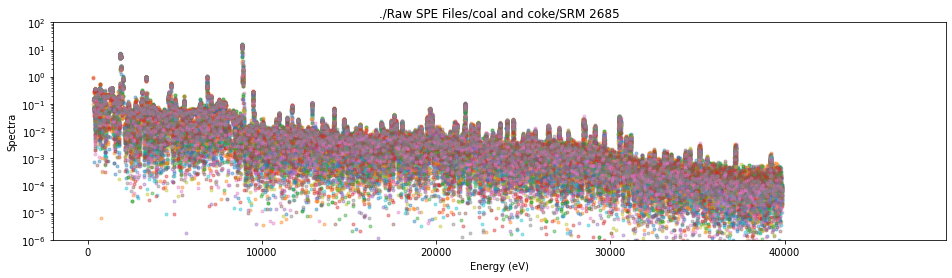

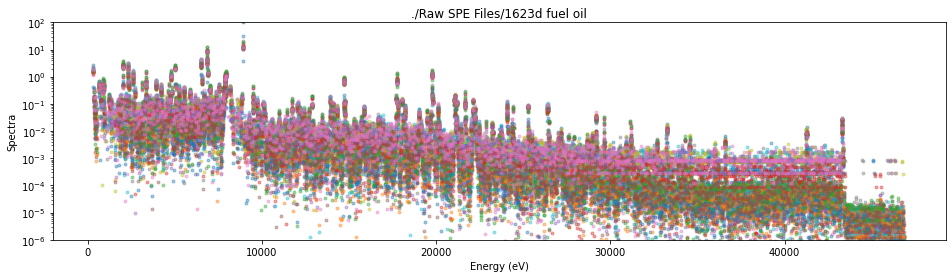

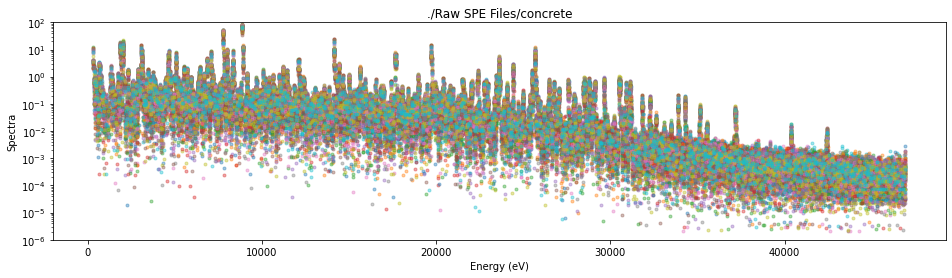

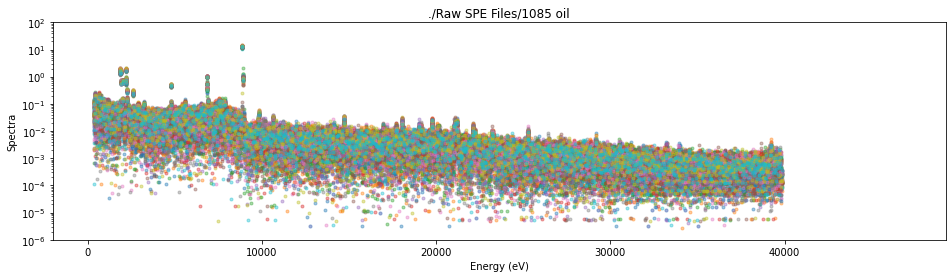

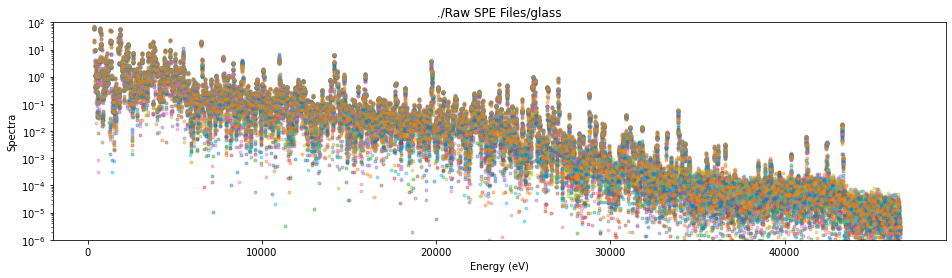

In [25]:
for label in df_min['label'].unique():
    plt.figure(figsize=(16,4))
    y_ = df_min[df_min['label'] == label].drop('label', axis=1).values
    _ = [plt.plot(aligned_centers[drop:], a, '.', alpha=0.4) 
         for a in f.transform(y_[:,drop:])]
    plt.yscale('log')
    plt.ylim(1e-6, 1e2)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Spectra')
    plt.title(label)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_min.drop(np.arange(drop).tolist()+['label'], axis=1).values, 
                                                    df_min['label'].values, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=df_min['label'].values
                                                   )

In [27]:
X_foreign = df_foreign.drop(np.arange(drop).tolist()+['label'], axis=1).values
y_foreign = df_foreign['label'].values

## Simple Models

### PCA (Unsupervised)

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


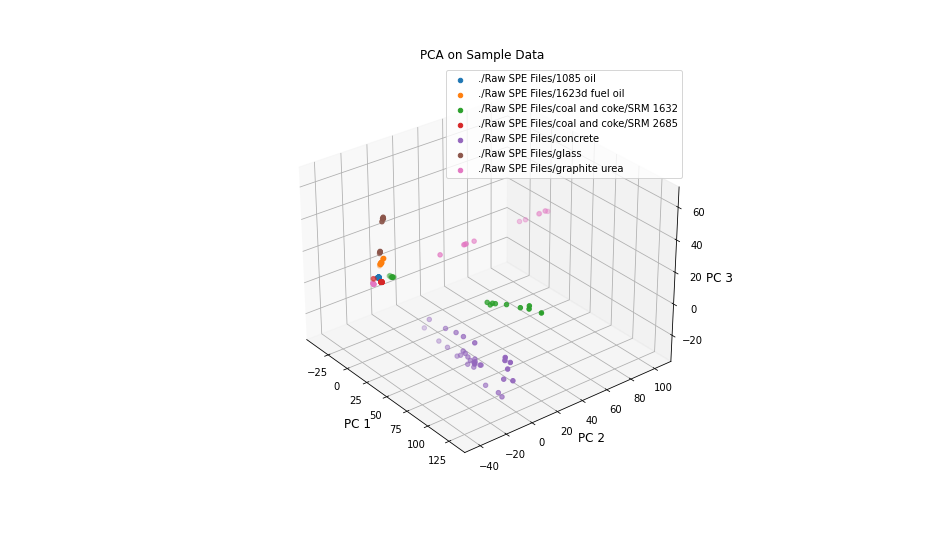

In [30]:
pca = PCA(n_components=3)
ss = StandardScaler()
X_proj = pca.fit_transform(ss.fit_transform(X_train))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_ in np.unique(y_train):
    mask = y_train == class_
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=class_)
ax.legend(loc='best')
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_zlabel('PC 3', fontsize=12)
ax.set_title('PCA on Sample Data', fontsize=12)
ax.view_init(elev=20., azim=-45)

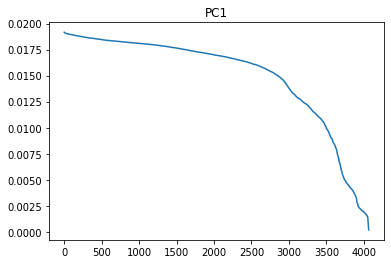

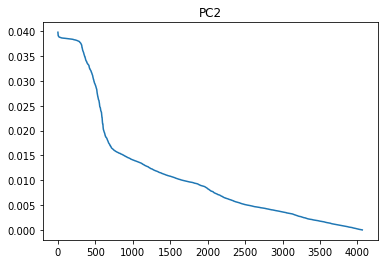

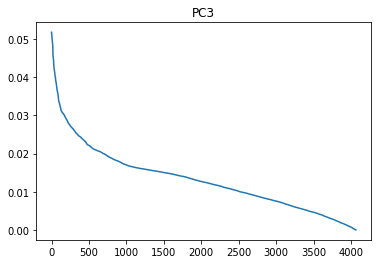

In [31]:
# Most "important" spectral readings from start - index of ~ 3000 for PC1
# Other PCs mostly focus on using progessively lower energy readings.

%matplotlib inline
for i in range(3):
    plt.figure()
    plt.title('PC{}'.format(i+1))
    comps = np.array(sorted(zip(np.arange(X_train.shape[1]), 
                                np.abs(pca.components_[i])), 
                            key=lambda x:np.abs(x[1]), 
                            reverse=True))
    plt.plot(comps[:,1])

### LDA (Supervised)

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [33]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


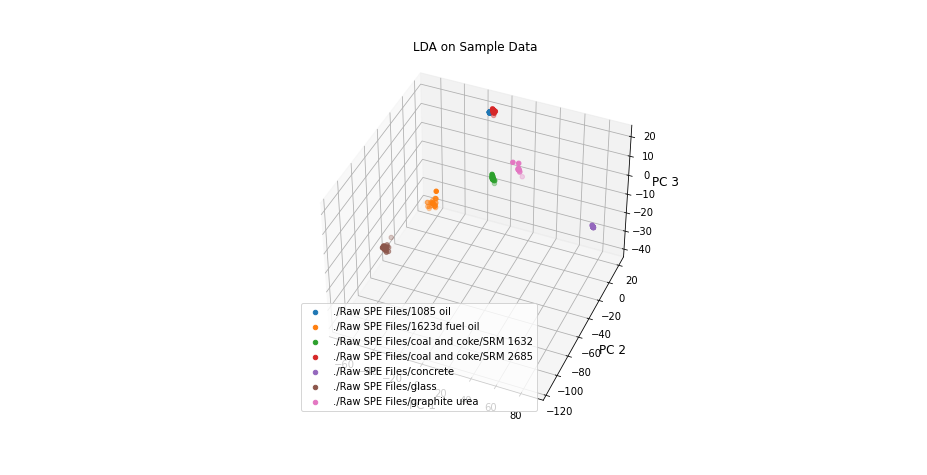

In [34]:
lda = LDA(n_components=3, store_covariance=True)
ss = StandardScaler()
X_proj = lda.fit_transform(ss.fit_transform(X_train), y_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for class_ in np.unique(y_train):
    mask = y_train == class_
    ax.scatter(X_proj[mask,0], X_proj[mask,1], X_proj[mask,2], label=class_)
ax.legend(loc='best')
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_zlabel('PC 3', fontsize=12)
ax.set_title('LDA on Sample Data', fontsize=12)
ax.view_init(elev=20., azim=-45)

In [35]:
# These samples are very different and quite easy to separate with discriminant models.

# Soft PLS-DA

In [36]:
from chemometrics.classifier.plsda import PLSDA

## Optimize a Model

In [37]:
# Let's optimize a PLS-DA model based on its total efficiency (TEFF). 
# We will also use some signal pre-processing in the pipeline.

pipeline = imblearn.pipeline.Pipeline(steps=[
    ("savgol", SavGol(
        window_length=7,
        polyorder=3,
        deriv=0, 
        delta=1
    )),
    ("plsda", PLSDA(n_components=3, 
                    alpha=0.05,
                    gamma=0.01,
                    scale_x=True, 
                    not_assigned='UNKNOWN',
                    style='soft', 
                    score_metric='TEFF'
                   )
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    'savgol__deriv': [1, 2], # If you allow 0 it seems this is optimal, but maybe not scientific.
    'plsda__n_components':np.arange(1, min_counts/2, dtype=int),
    'plsda__alpha': [0.05], 
    'plsda__scale_x': [True, False], 
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=3, 
        shuffle=True, 
        random_state=0,
    ),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)


47 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "../../../chemometrics/classifier/plsda.py", line 325, in fit
    np.linalg.cholesky(self.__S_[i])
  File "<__array_function__ internals>", line 6, in cholesky
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 763, in cholesky
    r = gufunc(a, signature=signature, extobj=extobj)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/linalg/linalg.py", line 91, in _raise_linalgerror_nonposdef
    raise LinAlgError("Matrix is not positive definite")
numpy.linalg.LinAlgError: Matrix is not positive definite

Duri

In [38]:
gs.score(X_train, y_train)

0.963212218453326

In [39]:
gs.score(X_test, y_test) # Quite good!

0.9440891630699332

In [40]:
gs.best_params_ 

{'plsda__alpha': 0.05,
 'plsda__n_components': 7,
 'plsda__scale_x': False,
 'savgol__deriv': 1}

In [41]:
# Were their any outliers detected at the given gamma=0.01? 
np.any(gs.best_estimator_.named_steps['plsda'].check_outliers())
# Might consider iteratively "cleaning" the dataset as in Rodionova OY., Pomerantsev AL. 
# "Detection of Outliers in Projection-Based Modeling", Anal. Chem. 2020, 92, 2656−2664.

True

In [42]:
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_test),
    y_test
)

In [43]:
df

,./Raw SPE Files/1085 oil,./Raw SPE Files/1623d fuel oil,./Raw SPE Files/coal and coke/SRM 1632,./Raw SPE Files/coal and coke/SRM 2685,./Raw SPE Files/concrete,./Raw SPE Files/glass,./Raw SPE Files/graphite urea,UNKNOWN
./Raw SPE Files/1085 oil,7,0,0,0,0,0,0,1
./Raw SPE Files/1623d fuel oil,0,5,0,0,0,0,0,1
./Raw SPE Files/coal and coke/SRM 1632,0,0,6,0,0,0,0,0
./Raw SPE Files/coal and coke/SRM 2685,0,0,0,9,0,0,0,1
./Raw SPE Files/concrete,0,0,0,0,8,0,0,0
./Raw SPE Files/glass,0,0,0,0,0,2,0,2
./Raw SPE Files/graphite urea,0,0,0,0,0,0,4,0


In [44]:
CSNS

./Raw SPE Files/1085 oil                  0.875000
./Raw SPE Files/1623d fuel oil            0.833333
./Raw SPE Files/coal and coke/SRM 1632    1.000000
./Raw SPE Files/coal and coke/SRM 2685    0.900000
./Raw SPE Files/concrete                  1.000000
./Raw SPE Files/glass                     0.500000
./Raw SPE Files/graphite urea             1.000000
dtype: float64

In [45]:
CSPS

./Raw SPE Files/1085 oil                  1.0
./Raw SPE Files/1623d fuel oil            1.0
./Raw SPE Files/coal and coke/SRM 1632    1.0
./Raw SPE Files/coal and coke/SRM 2685    1.0
./Raw SPE Files/concrete                  1.0
./Raw SPE Files/glass                     1.0
./Raw SPE Files/graphite urea             1.0
dtype: float64

In [46]:
# Excellent specificity! Problems are purely from sensitivity (unknowns instead of true class), but recall that
# we fixed alpha = 0.05 so we are always going to have some of that.  This is understandable.  

In [47]:
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_train),
    y_train
)

In [48]:
df

,./Raw SPE Files/1085 oil,./Raw SPE Files/1623d fuel oil,./Raw SPE Files/coal and coke/SRM 1632,./Raw SPE Files/coal and coke/SRM 2685,./Raw SPE Files/concrete,./Raw SPE Files/glass,./Raw SPE Files/graphite urea,UNKNOWN
./Raw SPE Files/1085 oil,31,0,0,0,0,0,0,1
./Raw SPE Files/1623d fuel oil,0,19,0,0,0,0,0,2
./Raw SPE Files/coal and coke/SRM 1632,0,0,21,0,0,0,0,2
./Raw SPE Files/coal and coke/SRM 2685,0,0,0,33,0,0,0,5
./Raw SPE Files/concrete,0,0,0,0,32,0,0,0
./Raw SPE Files/glass,0,0,0,0,0,17,0,1
./Raw SPE Files/graphite urea,0,0,0,0,0,0,14,2


In [49]:
CSNS

./Raw SPE Files/1085 oil                  0.968750
./Raw SPE Files/1623d fuel oil            0.904762
./Raw SPE Files/coal and coke/SRM 1632    0.913043
./Raw SPE Files/coal and coke/SRM 2685    0.868421
./Raw SPE Files/concrete                  1.000000
./Raw SPE Files/glass                     0.944444
./Raw SPE Files/graphite urea             0.875000
dtype: float64

In [50]:
CSPS

./Raw SPE Files/1085 oil                  1.0
./Raw SPE Files/1623d fuel oil            1.0
./Raw SPE Files/coal and coke/SRM 1632    1.0
./Raw SPE Files/coal and coke/SRM 2685    1.0
./Raw SPE Files/concrete                  1.0
./Raw SPE Files/glass                     1.0
./Raw SPE Files/graphite urea             1.0
dtype: float64

In [51]:
# Let's consider the foreign objects
df, I, CSNS, CSPS, CEFF, TSNS, TSPS, TEFF = gs.best_estimator_.named_steps['plsda'].figures_of_merit(
    gs.predict(X_foreign),
    y_foreign
)

In [52]:
df # PERFECT performance!

,./Raw SPE Files/1085 oil,./Raw SPE Files/1623d fuel oil,./Raw SPE Files/coal and coke/SRM 1632,./Raw SPE Files/coal and coke/SRM 2685,./Raw SPE Files/concrete,./Raw SPE Files/glass,./Raw SPE Files/graphite urea,UNKNOWN
./Raw SPE Files/B in steel,0,0,0,0,0,0,0,16
./Raw SPE Files/coal and coke/SRM 2692,0,0,0,0,0,0,0,3
./Raw SPE Files/coal and coke/SRM 2693,0,0,0,0,0,0,0,8
./Raw SPE Files/coal and coke/SRM 2775,0,0,0,0,0,0,0,6
./Raw SPE Files/limestone,0,0,0,0,0,0,0,14
./Raw SPE Files/phosphate rock,0,0,0,0,0,0,0,7
./Raw SPE Files/ti alloy,0,0,0,0,0,0,0,11
./Raw SPE Files/wood chips/SRM 1515 biomass,0,0,0,0,0,0,0,1
./Raw SPE Files/wood chips/SRM 1547 biomass,0,0,0,0,0,0,0,2
./Raw SPE Files/wood chips/SRM 1573 biomass,0,0,0,0,0,0,0,2


## Explanations

In [103]:
# The amount of "background" in the SHAP explainer can be important.  Let's examine that explicitly.

In [119]:
averages = []
nvals = np.linspace(5, 101, 50)
for n in nvals:
    explainer = shap.KernelExplainer(
        model = gs.predict_proba, 
        data = shap.sample(X_train, int(n), random_state=0), # vs. data = X_train to use full training set
    )
    averages.append(explainer.expected_value)
averages = np.array(averages)

Using 101 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<IPython.core.display.Javascript object>


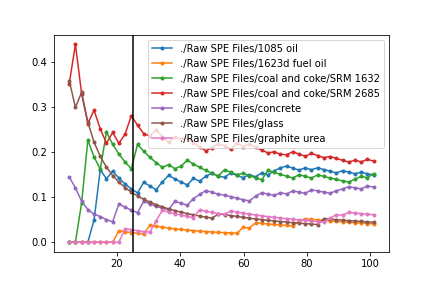

In [120]:
plt.figure()

for i, name in enumerate(gs.best_estimator_.named_steps['plsda'].categories):
    plt.plot(nvals, averages[:,i], '.-', label=name)
plt.legend(loc='best')
plt.axvline(25, color='k')

In [121]:
# Background average probability seems to become stable around n=25
explainer = shap.KernelExplainer(
    model = gs.predict_proba, 
    data = shap.sample(X_train, 25, random_state=0), # vs. data = X_train to use full training set
)

In [122]:
explainer.expected_value

array([0.11352396, 0.02041885, 0.19014708, 0.2696016 , 0.06820024,
       0.10644625, 0.02638588])

In [123]:
gs.best_estimator_.named_steps['plsda'].categories

array(['./Raw SPE Files/1085 oil', './Raw SPE Files/1623d fuel oil',
       './Raw SPE Files/coal and coke/SRM 1632',
       './Raw SPE Files/coal and coke/SRM 2685',
       './Raw SPE Files/concrete', './Raw SPE Files/glass',
       './Raw SPE Files/graphite urea'], dtype=object)

In [125]:
import pickle

try:
    shap_values_test = pickle.load(open('shap_values_test.pkl', 'rb'))
except:
    shap_values_test = explainer.shap_values(X_test, 
                                        nsamples='auto', # Can increase for lower variance
                                        l1_reg='num_features({})'.format(
                                            np.min(
                                                [X_test.shape[1], 20] # Only look at (up to) the top 20 features
                                            )
                                        )
                                       )
    pickle.dump(shap_values_test, open('shap_values_test.pkl', 'wb'))

  0%|          | 0/46 [00:00<?, ?it/s]

MemoryError: Unable to allocate 7.71 GiB for an array with shape (254450, 4066) and data type float64

In [ ]:
# fig = plt.figure(figsize=(10,6))

# for chosen_class in [0, 1, 2, 3]:
#     ax = fig.add_subplot(2, 2, chosen_class+1)
#     ax.set_title(gs.best_estimator_.named_steps['plsda'].categories[chosen_class])
#     sv = shap_values_test[chosen_class]

#     shap.summary_plot(
#         shap_values=sv,
#         features=X_test,
#         feature_names=analytes,
#         plot_type='violin',
#         max_display=10
#     )
# plt.tight_layout()

# SIMCA

In [364]:
from chemometrics.classifier.simca import SIMCA_Classifier

In [365]:
# The previous example of PLS-DA trains a single model to distinguish between all known classes, and possibly
# the unknown. An authentication model trains on a single class and uses the others (if provided) as 
# background to check the model's efficiency, but is not used during training.

## Optimize models

In [487]:
# Now let's optimize a SIMCA model based on its total efficiency (TEFF). 
# We will also use some signal pre-processing in the pipeline.

models = {}

for target in np.unique(y_train):
    pipeline = imblearn.pipeline.Pipeline(steps=[
        ("savgol", SavGol(
            window_length=7,
            polyorder=3,
            deriv=0, 
            delta=1
        )),
        ("simca", SIMCA_Classifier(n_components=7, 
                                   alpha=0.05, 
                                   scale_x=True, 
                                   style='dd-simca', 
                                   target_class=target, 
                                   use='TEFF')
        )
    ])

    # Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
    param_grid = [{
        'savgol__deriv': [1, 2], 
        'simca__n_components':np.arange(1, min_counts/2, dtype=int),
        'simca__alpha':[0.05],
        'simca__style':['dd-simca'],
        'simca__scale_x':[True, False] # True seems to cause inf because division by 0, I believe
    }]

    gs = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        n_jobs=-1,
        cv=sklearn.model_selection.StratifiedKFold(
            n_splits=3, 
            shuffle=True, 
            random_state=0
        ),
        error_score=0,
        refit=True
    )

    _ = gs.fit(X_train, y_train)
    
    models[target] = gs
    
    print(target, gs.best_params_)


54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit

./Raw SPE Files/1085 oil {'savgol__deriv': 1, 'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit

./Raw SPE Files/1623d fuel oil {'savgol__deriv': 1, 'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}
./Raw SPE Files/coal and coke/SRM 1632 {'savgol__deriv': 1, 'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit

./Raw SPE Files/coal and coke/SRM 2685 {'savgol__deriv': 2, 'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}
./Raw SPE Files/concrete {'savgol__deriv': 1, 'simca__alpha': 0.05, 'simca__n_components': 1, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit

./Raw SPE Files/glass {'savgol__deriv': 2, 'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}


/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)  # noqa
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/pipeline.py", line 711, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "../../../chemometrics/classifier/

./Raw SPE Files/graphite urea {'savgol__deriv': 1, 'simca__alpha': 0.05, 'simca__n_components': 2, 'simca__scale_x': False, 'simca__style': 'dd-simca'}



54 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nam/anaconda3/envs/py37/lib/python3.7/site-packages/imblearn/pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "../../../chemometrics/classifier/simca.py", line 146, in fit
    self.__model_.fit(X[y == self.target_class], y[y == self.target_class])
  File "../../../chemometrics/classifier/simca.py", line 763, in fit
    self.__pca_.fit

In [488]:
for target in models:
    print('Best SIMCA model for {} has TEFF (train) = {}, TEFF (test) = {}'.format(
        target,
        '%.4f'%models[target].score(X_train, y_train),
        '%.4f'%models[target].score(X_test, y_test))
    )

Best SIMCA model for ./Raw SPE Files/1085 oil has TEFF (train) = 0.9682, TEFF (test) = 0.9354
Best SIMCA model for ./Raw SPE Files/1623d fuel oil has TEFF (train) = 0.9258, TEFF (test) = 0.9129
Best SIMCA model for ./Raw SPE Files/coal and coke/SRM 1632 has TEFF (train) = 1.0000, TEFF (test) = 1.0000
Best SIMCA model for ./Raw SPE Files/coal and coke/SRM 2685 has TEFF (train) = 0.9177, TEFF (test) = 0.9487
Best SIMCA model for ./Raw SPE Files/concrete has TEFF (train) = 1.0000, TEFF (test) = 1.0000
Best SIMCA model for ./Raw SPE Files/glass has TEFF (train) = 1.0000, TEFF (test) = 0.8660
Best SIMCA model for ./Raw SPE Files/graphite urea has TEFF (train) = 0.9354, TEFF (test) = 1.0000


In [489]:
# All models have PERFECT performance on other foreign objects
for target in models:
    print('%.4f'%models[target].score(X_foreign, y_foreign), target)

1.0000 ./Raw SPE Files/1085 oil
1.0000 ./Raw SPE Files/1623d fuel oil
1.0000 ./Raw SPE Files/coal and coke/SRM 1632
1.0000 ./Raw SPE Files/coal and coke/SRM 2685
1.0000 ./Raw SPE Files/concrete
1.0000 ./Raw SPE Files/glass
1.0000 ./Raw SPE Files/graphite urea


In [490]:
# All are quite good! Again, glass is not great, but ok.

In [491]:
class_specificity = []
for k in sorted(models.keys()):
    _ = models[k].best_estimator_.named_steps['simca'].score(X_train, y_train)
    csps = models[k].best_estimator_.named_steps['simca'].CSPS
    row = []
    for x in sorted(np.unique(y_train)):
        if x == k:
            row.append(-1)
        else:
            row.append(csps[x])
    print('Optimal number of dims for {} : {}'.format(k, models[k].best_params_['simca__n_components']))
    class_specificity.append(row)

Optimal number of dims for ./Raw SPE Files/1085 oil : 1
Optimal number of dims for ./Raw SPE Files/1623d fuel oil : 1
Optimal number of dims for ./Raw SPE Files/coal and coke/SRM 1632 : 2
Optimal number of dims for ./Raw SPE Files/coal and coke/SRM 2685 : 2
Optimal number of dims for ./Raw SPE Files/concrete : 1
Optimal number of dims for ./Raw SPE Files/glass : 2
Optimal number of dims for ./Raw SPE Files/graphite urea : 2


In [492]:
# Note how all are very low D - this is consistent with the early PCA results showing that PCA on its own
# was able to separate classes in an unsupervised fashion.

In [493]:
pd.DataFrame(data=class_specificity, columns=sorted(np.unique(y_train)), index=sorted(models.keys()))

,./Raw SPE Files/1085 oil,./Raw SPE Files/1623d fuel oil,./Raw SPE Files/coal and coke/SRM 1632,./Raw SPE Files/coal and coke/SRM 2685,./Raw SPE Files/concrete,./Raw SPE Files/glass,./Raw SPE Files/graphite urea
./Raw SPE Files/1085 oil,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
./Raw SPE Files/1623d fuel oil,1.0,-1.0,1.0,1.0,1.0,1.0,1.0
./Raw SPE Files/coal and coke/SRM 1632,1.0,1.0,-1.0,1.0,1.0,1.0,1.0
./Raw SPE Files/coal and coke/SRM 2685,1.0,1.0,1.0,-1.0,1.0,1.0,1.0
./Raw SPE Files/concrete,1.0,1.0,1.0,1.0,-1.0,1.0,1.0
./Raw SPE Files/glass,1.0,1.0,1.0,1.0,1.0,-1.0,1.0
./Raw SPE Files/graphite urea,1.0,1.0,1.0,1.0,1.0,1.0,-1.0


In [494]:
%matplotlib notebook

In [504]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14,30))
for ax, target in zip(axes.flatten(), models.keys()):
    X_t = models[target].best_estimator_.named_steps['savgol'].transform(X_test)
    models[target].best_estimator_.named_steps['simca'].model.visualize(X_t, y_test, ax=ax)
    ax.set_title('Model for {}'.format(target))
    ax.legend(loc='best')
plt.tight_layout()

<IPython.core.display.Javascript object>

## Explanations